<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_08_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Explore the MNIST Data Set

In [2]:
# Import the dataset (it comes with colab)
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

In [3]:
data.shape

(20000, 785)

In [4]:
# Extract labels (number IDs) and remove from the data
labels = data[:,0]
data = data[:,1:]
print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [5]:
labels[0:15]

array([6., 5., 7., 9., 5., 2., 0., 6., 5., 5., 2., 7., 7., 6., 8.])

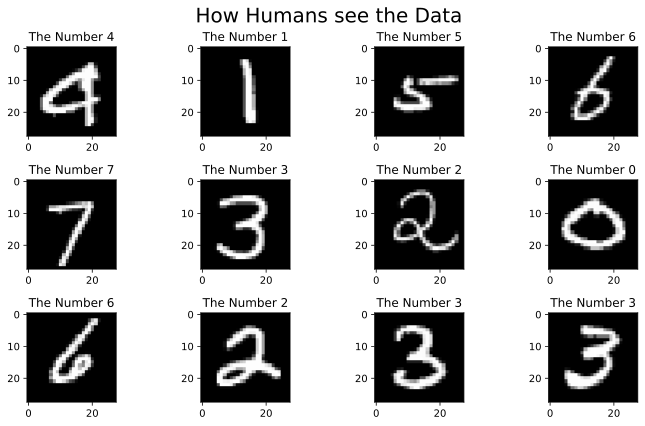

In [6]:
# Plot a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

# We need to reshape the data
for ax in axs.flatten():
    # Pick a random image
    randimg2show = np.random.randint(0, high=data.shape[0])

    # Create the image (must be reshaped)
    img = np.reshape(data[randimg2show,:], (28,28))
    ax.imshow(img, cmap="gray")

    # Title
    ax.set_title("The Number %i"%labels[randimg2show])

plt.suptitle("How Humans see the Data", fontsize=20)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

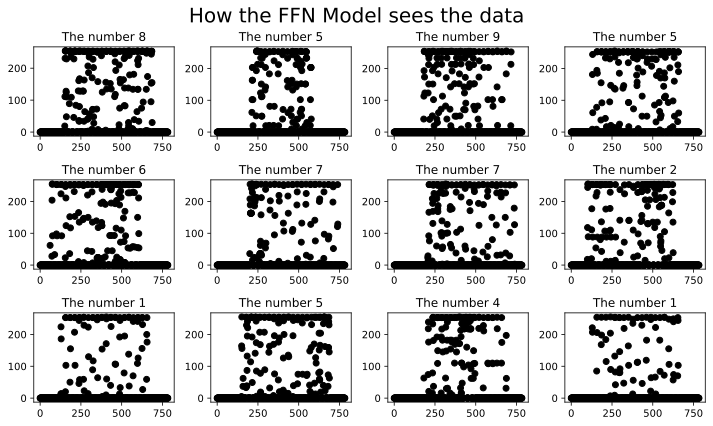

In [7]:
# How images are sen by he model
fig,ax = plt.subplots(3,4,figsize=(10,6))

for axs in ax.flatten():
    # Pick a random image
    randimg2show = np.random.randint(0, high=data.shape[0])

    # Create the image
    axs.plot(data[randimg2show,:],"ko")

    # title
    axs.set_title("The number %i"%labels[randimg2show])

plt.suptitle("How the FFN Model sees the data", fontsize=20)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

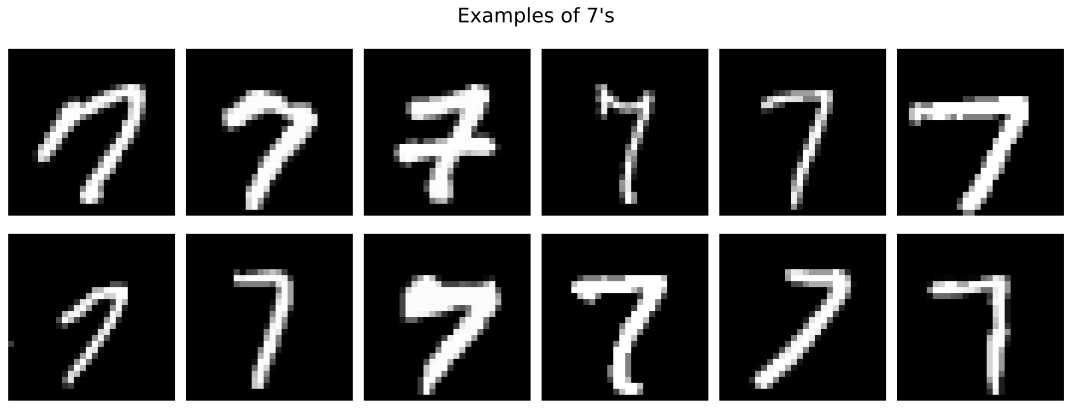

In [8]:
# Let's see some 7's, one of the mot confusin digits
# Find indices of all 7s in the dataset (Creates a tupple of array, therefote extract the array)
the7s = np.where(labels==7)[0]

# Draw the first 12 images
fig, ax = plt.subplots(2,6,figsize=(15,6))

for i,axs in enumerate(ax.flatten()):
    img = np.reshape(data[the7s[i],:],(28,28))
    axs.imshow(img,cmap="gray")
    axs.axis("off")

plt.suptitle("Examples of 7's", fontsize=20)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [9]:
# The total number of 7's out there
print(data[the7s,:].shape)

(2126, 784)


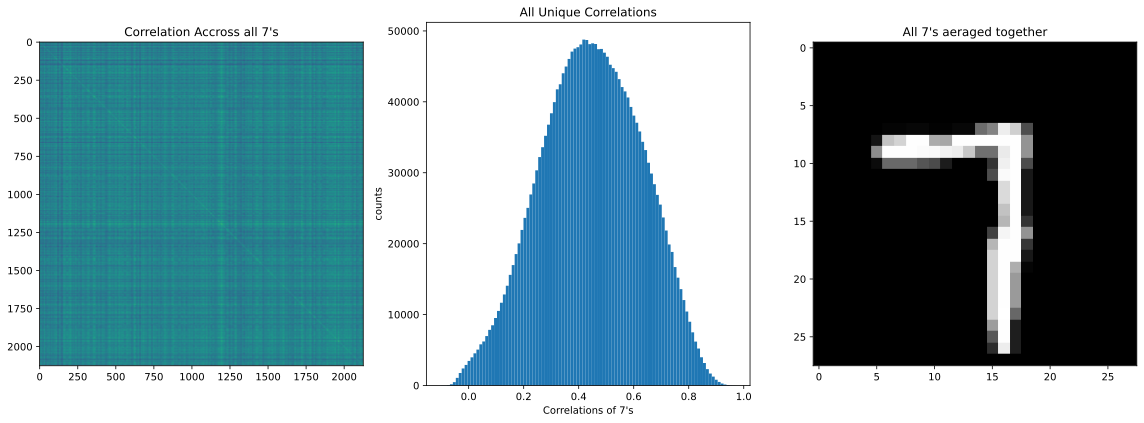

In [10]:
# Compute spatial correlation to see how correlated 7's are to each other
C = np.corrcoef(data[the7s,:])

# Visualize
fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].imshow(C,vmin=0, vmax=1)
ax[0].set_title("Correlation Accross all 7's")

# Extract unique correlations and draw scatterplots
uniqueCs = np.triu(C,k=1).flatten()
ax[1].hist(uniqueCs[uniqueCs !=0], bins=100)
ax[1].set_title("All Unique Correlations")
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel("counts")

# Show all 7's together
aveAll7s = np.reshape(np.mean(data[the7s,:],axis=0),(28,28))
ax[2].imshow(img,cmap="gray")
ax[2].set_title("All 7's aeraged together")

plt.tight_layout()
plt.show()

# FFN to Classify Digits

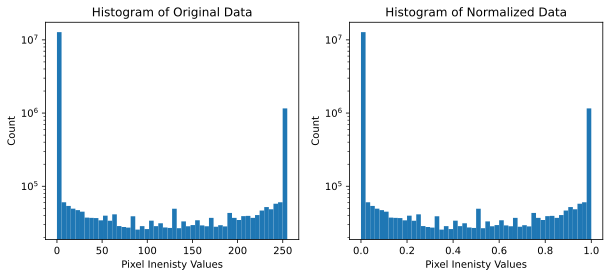

In [11]:
# We will use the same MNIST small dataset
# Normalize the data to 0-1 range
dataNorm = data/np.max(data)

# Visualize the difference between original and normalized data
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel("Pixel Inenisty Values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of Original Data")
ax[0].set_yscale("log")

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel("Pixel Inenisty Values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of Normalized Data")
ax[1].set_yscale("log")

plt.show()

In [12]:
# Prepare data for modeling

# Step 1: Conver the data into Tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64 (integers)

# Step2: Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
# Check all Variabels in the workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
C                  ndarray          2126x2126: 4519876 elems, type `float64`, 36159008 bytes (34.483917236328125 Mb)
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
aveAll7s           ndarray          28x28: 784 elems, type `float64`, 6272 bytes
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
axs                AxesSubplot      AxesSubplot(0.835,0.066599;0.155x0.3875)
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor         

In [14]:
# Create the Deep Learning Model
def createTheMNISTNet():

    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784,64)

            # Hidden Layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # Output Layer
            self.output = nn.Linear(32,10)
        
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.output(x)
            return torch.log_softmax(x,axis=1)
    
    # Create the model instance
    net = MnistNet()

    # Loss function
    # Negative log-likelyhood loss
    lossfun = nn.NLLLoss()

    # Optmizer
    # Use SGD for slower learning, not Adam
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [15]:
# Test the model with single batch
net, lossfun, optimizer = createTheMNISTNet()

X,y = iter(train_loader).next()
yHat = net(X)

# Values are log-probability
print(yHat.shape)
print()
print(yHat)
# Log of probability of model output

torch.Size([32, 10])

tensor([[-2.3101, -2.1563, -2.4317, -2.4043, -2.3844, -2.3068, -2.2378, -2.4447,
         -2.2928, -2.1150],
        [-2.3288, -2.1714, -2.4228, -2.3966, -2.3766, -2.3284, -2.2175, -2.4278,
         -2.2713, -2.1348],
        [-2.3232, -2.1645, -2.4127, -2.3940, -2.3727, -2.3248, -2.2289, -2.4327,
         -2.2781, -2.1418],
        [-2.3218, -2.1625, -2.4151, -2.3943, -2.3807, -2.3252, -2.2236, -2.4300,
         -2.2770, -2.1441],
        [-2.3166, -2.1805, -2.4044, -2.3876, -2.3852, -2.3323, -2.2208, -2.4395,
         -2.2641, -2.1417],
        [-2.3296, -2.1695, -2.4292, -2.4032, -2.3785, -2.3282, -2.2203, -2.4310,
         -2.2773, -2.1148],
        [-2.3233, -2.1672, -2.4315, -2.3943, -2.3924, -2.3269, -2.2137, -2.4165,
         -2.2701, -2.1407],
        [-2.3122, -2.1612, -2.4187, -2.3966, -2.3748, -2.3253, -2.2362, -2.4333,
         -2.2846, -2.1329],
        [-2.3163, -2.1589, -2.4097, -2.4090, -2.3779, -2.3360, -2.2347, -2.4439,
         -2.2773, -2.1176

In [16]:
# invert the above numbers into probabilities
# We have an untrained model, so values should be somewhere around 0.1
print(torch.exp(yHat))

tensor([[0.0992, 0.1158, 0.0879, 0.0903, 0.0921, 0.0996, 0.1067, 0.0868, 0.1010,
         0.1206],
        [0.0974, 0.1140, 0.0887, 0.0910, 0.0929, 0.0974, 0.1089, 0.0882, 0.1032,
         0.1183],
        [0.0980, 0.1148, 0.0896, 0.0913, 0.0932, 0.0978, 0.1076, 0.0878, 0.1025,
         0.1174],
        [0.0981, 0.1150, 0.0894, 0.0912, 0.0925, 0.0978, 0.1082, 0.0880, 0.1026,
         0.1172],
        [0.0986, 0.1130, 0.0903, 0.0918, 0.0921, 0.0971, 0.1085, 0.0872, 0.1039,
         0.1175],
        [0.0973, 0.1142, 0.0881, 0.0904, 0.0927, 0.0975, 0.1086, 0.0879, 0.1026,
         0.1207],
        [0.0980, 0.1145, 0.0879, 0.0912, 0.0914, 0.0976, 0.1093, 0.0892, 0.1033,
         0.1176],
        [0.0990, 0.1152, 0.0890, 0.0910, 0.0930, 0.0978, 0.1069, 0.0877, 0.1018,
         0.1185],
        [0.0986, 0.1154, 0.0898, 0.0899, 0.0927, 0.0967, 0.1070, 0.0868, 0.1026,
         0.1203],
        [0.0984, 0.1142, 0.0889, 0.0908, 0.0914, 0.0980, 0.1082, 0.0885, 0.1032,
         0.1183],
        [0

In [17]:
loss = lossfun(yHat,y)
print(loss)

tensor(2.2911, grad_fn=<NllLossBackward0>)


In [18]:
# Create function to train the model
def function2trainThemodel():

    # define epoch number
    numepochs = 60

    # Create new model
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the Losses
    losses = []
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Loop over the batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Accuracy
            matches = (torch.argmax(yHat,axis=1) == y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # End of batch training

        # Train Accuracy
        trainAcc.append(np.mean(batchAcc))
        # Losses
        losses.append(np.mean(batchLoss))

        # Test Accuracy
        X,y = next(iter(test_loader))
        yHat = net(X)

        # Test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    
    # Finish everything
    return trainAcc, testAcc, losses, net

In [19]:
# Run the Model
trainAcc, testAcc, losses, net = function2trainThemodel()

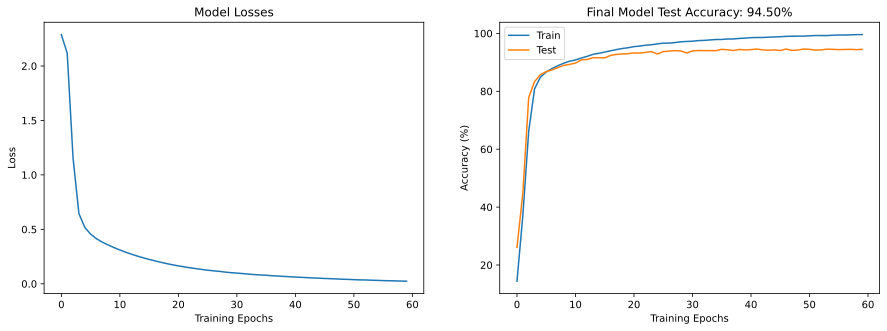

In [20]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

In [22]:
# Inspect results in mode detail
# Run the model through the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

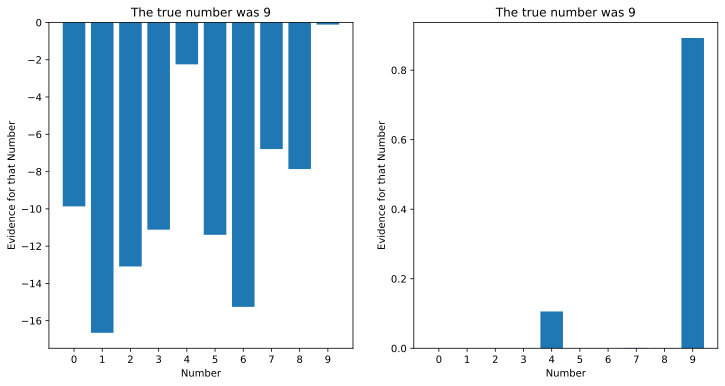

In [23]:
# Numbers from a sample
sample2show = 120
fig,ax = plt.subplots(1,2, figsize=(12,6))

ax[0].bar(range(10), predictions[sample2show])
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that Number")
ax[0].set_title("The true number was {}".format(y[sample2show].item()))

ax[1].bar(range(10), torch.exp(predictions[sample2show]))
ax[1].set_xticks(range(10))
ax[1].set_xlabel("Number")
ax[1].set_ylabel("Evidence for that Number")
ax[1].set_title("The true number was {}".format(y[sample2show].item()))
plt.show()

In [24]:
# Find the errors
errors = np.where(torch.max(predictions,axis=1)[1] !=y)[0]
print(errors)

[   1   11   13   19   34   36   48   51   55  112  175  201  204  222
  233  248  278  331  338  364  407  412  443  447  492  498  505  515
  522  534  559  591  613  632  642  646  682  726  740  750  760  764
  765  860  873  926  929  935  970  990 1042 1044 1049 1059 1061 1071
 1077 1079 1090 1098 1100 1123 1150 1164 1169 1172 1227 1245 1280 1304
 1308 1309 1311 1323 1327 1349 1400 1447 1461 1472 1474 1475 1497 1500
 1512 1514 1520 1541 1552 1553 1583 1637 1667 1684 1686 1687 1726 1769
 1797 1799 1800 1825 1834 1864 1886 1917 1919 1941 1967 1975]


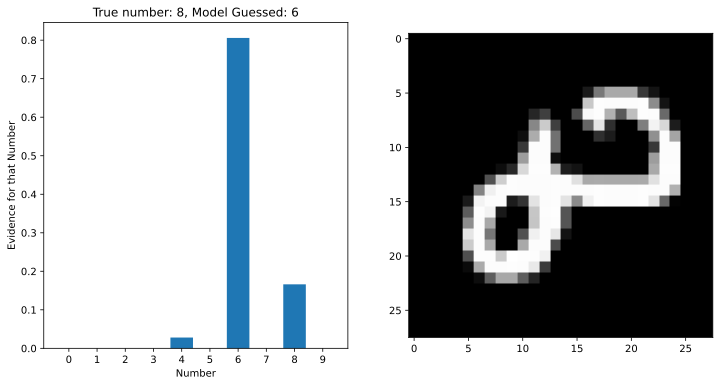

In [25]:
# Visualize some of the images
sample2show = 4
fig,ax = plt.subplots(1,2, figsize=(12,6))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that Number")
ax[0].set_title("True number: {}, Model Guessed: {}".format(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))

ax[1].imshow(np.reshape(X[errors[sample2show],:], (28,28)), cmap= "gray")

plt.show()

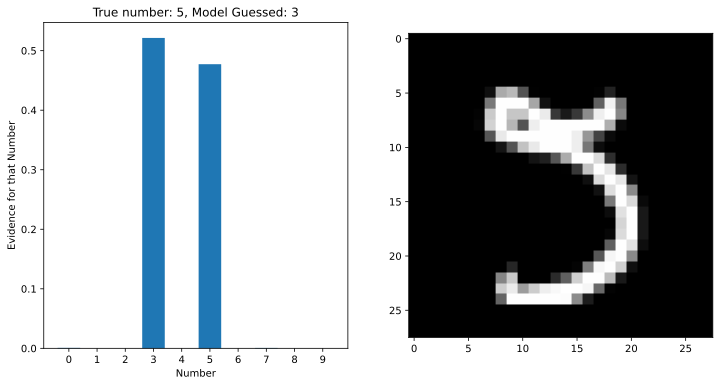

In [26]:
# Visualize some of the images
sample2show = 12
fig,ax = plt.subplots(1,2, figsize=(12,6))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that Number")
ax[0].set_title("True number: {}, Model Guessed: {}".format(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))

ax[1].imshow(np.reshape(X[errors[sample2show],:], (28,28)), cmap= "gray")

plt.show()

# Binarized MNIST Images

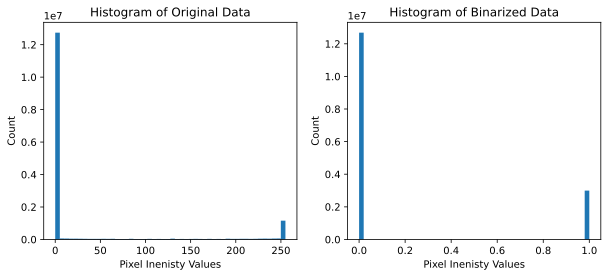

In [30]:
# Repeat the same model and metaparameters, but binarize the data to either 0 or 1 and then check performance

# Binarize the data
dataBin = (data > 0).astype(float)

# Check Graphically
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel("Pixel Inenisty Values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of Original Data")

ax[1].hist(dataBin.flatten(),50)
ax[1].set_xlabel("Pixel Inenisty Values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of Binarized Data")

plt.show()

In [29]:
# Conform that data has limited values
print(np.unique(data))
print()
print(np.unique(dataBin))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [31]:
# Step 1: Conver the data into Tensors
dataT = torch.tensor(dataBin).float()
labelsT = torch.tensor(labels).long() # long = int64 (integers)

# Step2: Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [32]:
# Run the Model
trainAcc, testAcc, losses, net = function2trainThemodel()

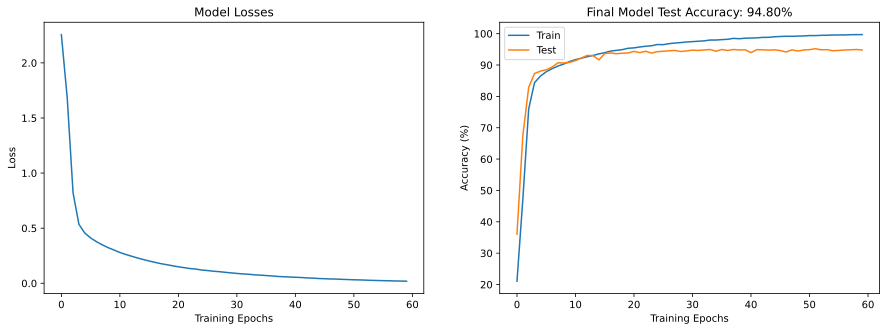

In [33]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()
# No difference!

# Data Normalization

Use the same code as before: This section is made of three parts:

1 - Normalize the training and test data on a range 0-1, plot accuracy

2 - Normalize the Train data on range 0-1, keave Test Data as it is, plot accuracy

3 - Keep Training data original, normalize test data 0-1 and plot accuracy

## Part 1

In [50]:
# Make some small changes to the training function
def function2trainThemodel():

    # define epoch number
    numepochs = 60

    # Create new model
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the Losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Loop over the batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Accuracy
            matches = (torch.argmax(yHat,axis=1) == y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # End of batch training

        # Train Accuracy
        trainAcc.append(np.mean(batchAcc))
        # Losses
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    
    # Finish everything
    return trainAcc, testAcc, losses, net

In [51]:
# Convert the whole dataset into tensor to be used in all following steps
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()

# Split the data into train and test
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = 0.1)

# Normalized Train and test Data
train_dataN = train_data/torch.max(train_data)
test_dataN = test_data/torch.max(test_data)

# Convert into PyTorch Datasets
train_dataP = TensorDataset(train_dataN, train_labels)
test_dataP = TensorDataset(test_dataN, test_labels)

# Translate into data Loader
batchsize = 32
train_loader = DataLoader(train_dataP, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataP, batch_size=test_dataP.tensors[0].shape[0])

In [52]:
# Confirm the ranges of train and test data
print("Training Data Range from {} to {}".format(
    torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))

print("Testing Data Range from {} to {}".format(
    torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

Training Data Range from 0.0 to 1.0
Testing Data Range from 0.0 to 1.0


In [53]:
# Run the Model
trainAcc, testAcc, losses, net = function2trainThemodel()

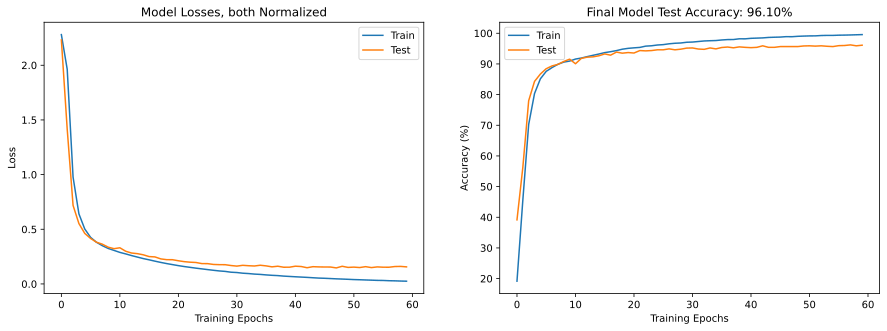

In [54]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(['Train','Test'])
ax[0].set_title("Model Losses, both Normalized")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

## Part 2

In [55]:
# Normalized Train leave test untouched
train_dataN = train_data/torch.max(train_data)

# Convert into PyTorch Datasets
train_dataP = TensorDataset(train_dataN, train_labels)
test_dataP = TensorDataset(test_data, test_labels)

# Translate into data Loader
batchsize = 32
train_loader = DataLoader(train_dataP, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataP, batch_size=test_dataP.tensors[0].shape[0])

In [56]:
# Run the Model
trainAcc, testAcc, losses, net = function2trainThemodel()

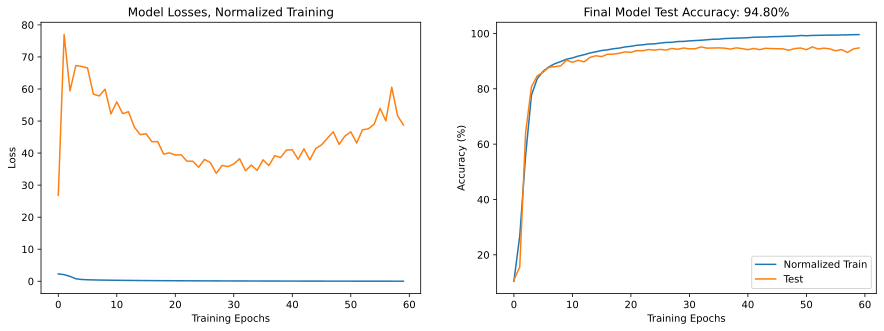

In [57]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Losses, Normalized Training")

ax[1].plot(trainAcc, label="Normalized Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

## Part 3

In [58]:
# Normalized Test, original train
test_dataN = test_data/torch.max(test_data)

# Convert into PyTorch Datasets
train_dataP = TensorDataset(train_data, train_labels)
test_dataP = TensorDataset(test_dataN, test_labels)

# Translate into data Loader
batchsize = 32
train_loader = DataLoader(train_dataP, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataP, batch_size=test_dataP.tensors[0].shape[0])

In [59]:
# Run the Model
trainAcc, testAcc, losses, net = function2trainThemodel()

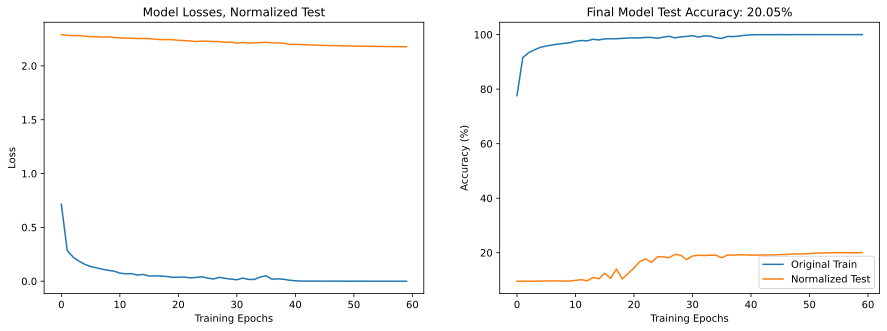

In [62]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Losses, Normalized Test")

ax[1].plot(trainAcc, label="Original Train")
ax[1].plot(testAcc, label="Normalized Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

# Weight Distribution During Learning

In [65]:
# We will use the normalized data
dataNorm = data/np.max(data)
# Step 1: Conver the data into Tensors
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64 (integers)

# Step2: Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [66]:
# Define the model class
# Create the Deep Learning Model
def createTheMNISTNet():

    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer (matrix 84x64)
            self.input = nn.Linear(784,64)

            # Hidden Layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # Output Layer
            self.output = nn.Linear(32,10)
        
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x) # We are usinf crossentropy as loss function this time
    
    # Create the model instance
    net = MnistNet()

    # Loss function
    # Negative log-likelyhood loss
    lossfun = nn.CrossEntropyLoss()

    # Optmizer
    # Use SGD for slower learning, not Adam
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

    return net, lossfun, optimizer

In [67]:
# Exploring the innards of the model

# Create a template model to explore whats going on
net = createTheMNISTNet()[0]

# Summary of the entire model
print("Summary if the Model")
print(net)

Summary if the Model
MnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


In [68]:
# Explore one of the layers
print("Summary of the Input Layer")
print(vars(net.input))

Summary of the Input Layer
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0238,  0.0137, -0.0337,  ...,  0.0075,  0.0320,  0.0125],
        [ 0.0314, -0.0073, -0.0106,  ...,  0.0256, -0.0150,  0.0344],
        [ 0.0169, -0.0289, -0.0038,  ...,  0.0042, -0.0009,  0.0057],
        ...,
        [-0.0003,  0.0213,  0.0253,  ...,  0.0026,  0.0024, -0.0216],
        [ 0.0128, -0.0189, -0.0296,  ...,  0.0197,  0.0258,  0.0326],
        [ 0.0339,  0.0306, -0.0223,  ...,  0.0006,  0.0285,  0.0148]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 3.4022e-02,  5.6418e-03,  1.3122e-02,  3.4613e-02,  9.9650e-03,
         2.8733e-02,  2.2033e-02,  8.2147e-03,  2.1314e-02, -1.8128e-02,
        -1.6586e-02, -1.9308e-02, -2.0872e-02, -3.3604e-02, -6.6065e-03,
        -2.6268e-02, -3.0988e-02, -2.1440e-02,  1.9985e-02,  1.8981e-02,
         8.0107e-03,  1.2834e-02, -2.3136e-02, -9.2116e-03,  2.0883e-02,
        -3.1815e-02,  5.7273e-03, 

In [69]:
# Check the matrix of weights
print("Input layer weights")
print(net.input.weight.shape)
print()
print(net.input.weight)

Input layer weights
torch.Size([64, 784])

Parameter containing:
tensor([[-0.0238,  0.0137, -0.0337,  ...,  0.0075,  0.0320,  0.0125],
        [ 0.0314, -0.0073, -0.0106,  ...,  0.0256, -0.0150,  0.0344],
        [ 0.0169, -0.0289, -0.0038,  ...,  0.0042, -0.0009,  0.0057],
        ...,
        [-0.0003,  0.0213,  0.0253,  ...,  0.0026,  0.0024, -0.0216],
        [ 0.0128, -0.0189, -0.0296,  ...,  0.0197,  0.0258,  0.0326],
        [ 0.0339,  0.0306, -0.0223,  ...,  0.0006,  0.0285,  0.0148]],
       requires_grad=True)


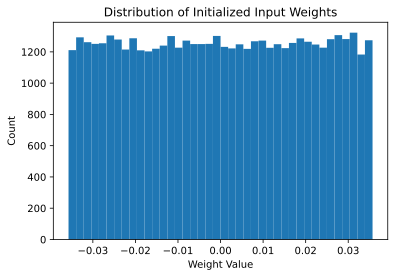

In [70]:
# Extract weights and plot a histogram
w = net.input.weight.detach().flatten() # emove other functions, convert matrix to vector
plt.hist(w,40)
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.title("Distribution of Initialized Input Weights")
plt.show()
# Uniform distribution, symmetric around zero

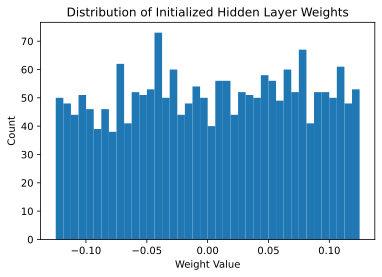

In [71]:
# Extract weights of hidden layer 1
w = net.fc1.weight.detach().flatten() # emove other functions, convert matrix to vector
plt.hist(w,40)
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.title("Distribution of Initialized Hidden Layer Weights")
plt.show()
# Uniform distribution, symmetric around zero

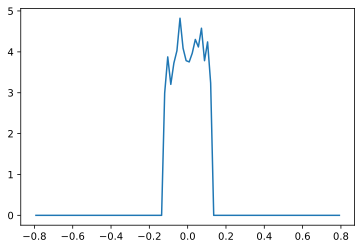

In [77]:
# Define a function hat returns a histogram of all weights accross all layers
def weightsHistogram(net):

    # Initialize the weights vector
    W = np.array([])

    # Concatenate each set of weights
    for layer in net.parameters():
        W = np.concatenate((W, net.fc1.weight.detach().flatten().numpy()))
    
    # Compute their histogram
    histy, histx = np.histogram(W, bins=np.linspace(-0.8, 0.8, 101), density=True)
    histx = (histx[1:] + histx[:-1])/2
    return histx, histy

# Test it to make sure it works (This is for all layers)
histx, histy = weightsHistogram(net)
plt.plot(histx,histy)
plt.show()

In [79]:
# Introduce the histogram in the function
def function2trainThemodel():

    # define epoch number
    numepochs = 100

    # Create new model
    net, lossfun, optimizer = createTheMNISTNet()

    # Initialize the Losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Initialize Historam variables
    histx = np.zeros((numepochs,100))
    histy = np.zeros((numepochs,100))

    # Loop over the epochs
    for epochi in range(numepochs):

        # Weight Distributions at the beginning of each epoch
        histx, histy[epochi,:] = weightsHistogram(net)

        # Loop over the batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # forward pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Accuracy
            matches = (torch.argmax(yHat,axis=1) == y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # End of batch training

        # Train Accuracy
        trainAcc.append(np.mean(batchAcc))
        # Losses
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # Test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    
    # Finish everything
    return trainAcc, testAcc, losses, net, histx, histy

In [80]:
# Run the model
trainAcc, testAcc, losses, net, histx, histy = function2trainThemodel()

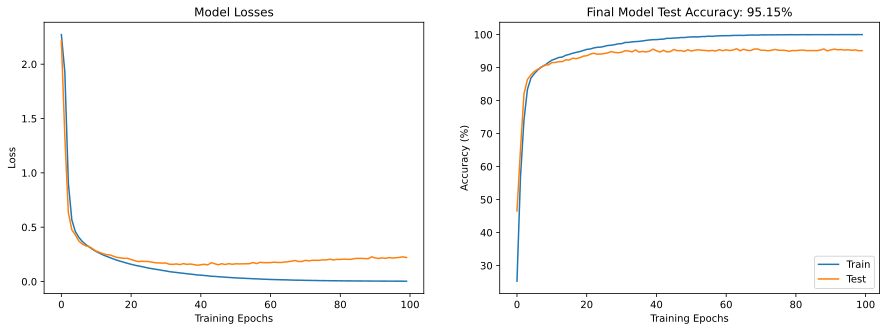

In [81]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

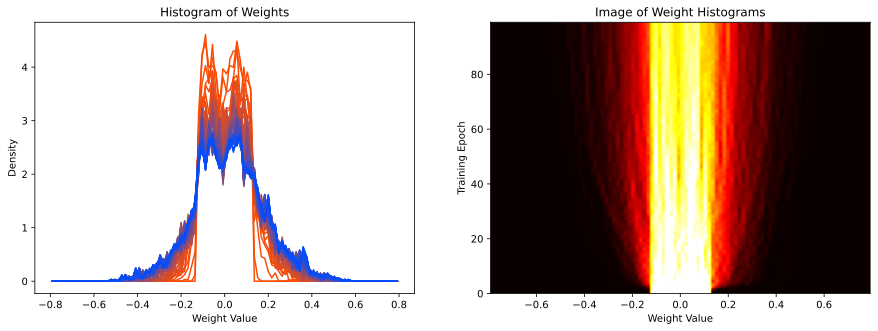

In [86]:
# Show the histogram of weights
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
    ax[0].plot(histx,histy[i,:], color=[1-i/100, 0.3, i/100])

ax[0].set_title("Histogram of Weights")
ax[0].set_xlabel("Weight Value")
ax[0].set_ylabel("Density")

ax[1].imshow(histy, vmin=0, vmax=3,
             extent = [histx[0], histx[-1],0,99], aspect="auto", origin="top", cmap="hot")
ax[1].set_xlabel("Weight Value")
ax[1].set_ylabel("Training Epoch")
ax[1].set_title("Image of Weight Histograms")
plt.show()
# Orange lines are at the beginning, then htey shift towards blue

# MNIST: Breadth vs Depth